# Time series clustering based on autocorrelation

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from statsmodels.tsa.arima_process import ArmaProcess

/Users/willie/.local/share/virtualenvs/time-series-demos-svg3QhUy/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## 1 Define the data generating processes

In [2]:
# Define the ARMA processes. AR params must be negated. See
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_process.ArmaProcess.html
processes = [
    ArmaProcess.from_coeffs([], []),
    ArmaProcess.from_coeffs([-0.5], []),
    ArmaProcess.from_coeffs([], [0.9]),
    ArmaProcess.from_coeffs([0.5], [0.5])
]

## 2 Generate samples from each process 

In [3]:
# Number of time series per process
series_per_process = 3

# Length of an individual time series
T = 1_000

n_processes = len(processes)
n_series = n_processes * series_per_process

# Generate the time series.
df = pd.DataFrame()
for i in range(n_series):
    df[f"TS_{i}"] = processes[i // series_per_process].generate_sample(T)

In [4]:
df.head(10)

,TS_0,TS_1,TS_2,TS_3,TS_4,TS_5,TS_6,TS_7,TS_8,TS_9,TS_10,TS_11
0,-1.438818,-0.573910,-0.065737,2.760299,-0.433184,-1.416115,-0.483618,-0.068732,-1.029777,0.644307,-1.914555,-0.423764
1,-0.175397,1.184052,0.704682,-2.891906,0.138348,0.868990,-0.992950,-1.276142,-0.589937,-1.195877,-2.291995,-0.461112
2,-1.758888,-1.712560,-0.880651,0.141050,0.796920,-0.883305,-0.754607,-3.159513,0.160435,-2.113796,-1.522508,0.693331
3,-2.430599,-1.087676,1.840736,0.718839,-0.874900,0.676490,-2.199578,-2.974652,1.872746,-1.494704,-2.134007,1.484826
4,-0.400740,-0.296076,-1.684807,-0.178245,0.331558,-0.103439,-1.015688,1.029140,0.774337,0.154581,-1.211514,1.366234
5,-0.136707,1.953398,-1.837255,0.841446,-0.467048,-1.231490,-0.038159,1.281238,-0.425304,-0.629079,1.014020,2.529650
6,0.558422,1.753004,0.949350,-0.305722,-0.009629,1.236935,-3.160512,-0.679359,-0.078704,-0.493840,1.420515,2.984768
7,2.516693,0.249815,-0.235760,1.387333,0.704835,-0.608962,-1.044075,-0.276751,-0.142883,-0.583438,1.750251,3.204853
8,-0.054629,0.026811,-0.743202,-1.840542,0.022885,1.415509,2.520796,0.737167,-0.243195,0.099172,1.819176,2.205025
9,1.787810,0.312723,0.792665,0.700897,-0.423242,-1.160429,0.882364,0.593478,-1.917836,0.005366,0.981554,-0.373432


In [5]:
def plot_df(df, lower, upper, process):
    n_rows = upper - lower
    fig, ax = plt.subplots(
        nrows=n_rows, ncols=1,
        sharex=True, sharey=False,
        figsize=(12, 2 * n_rows),
        tight_layout=True)
    fig.suptitle(f"TS {lower}-{upper-1}\n{process}")
    for i in range(n_rows):
        ts_idx = lower + i
        ax[i].plot(df.iloc[:, ts_idx])
        #ax[i].set_title(f"TS {ts_idx}")
    plt.show()

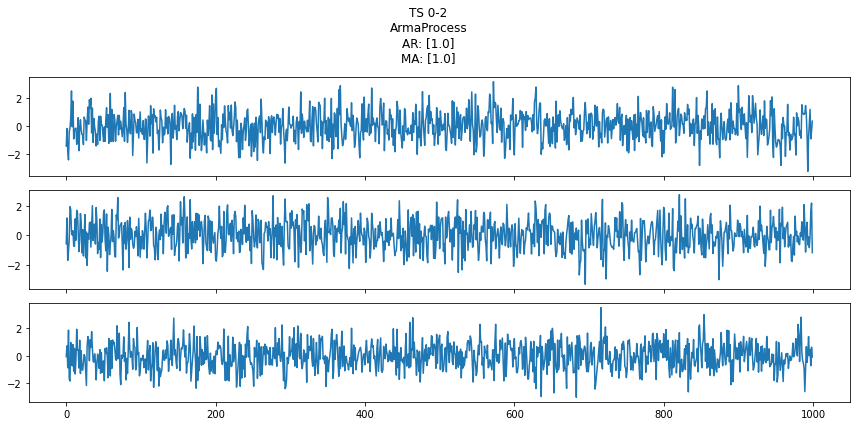

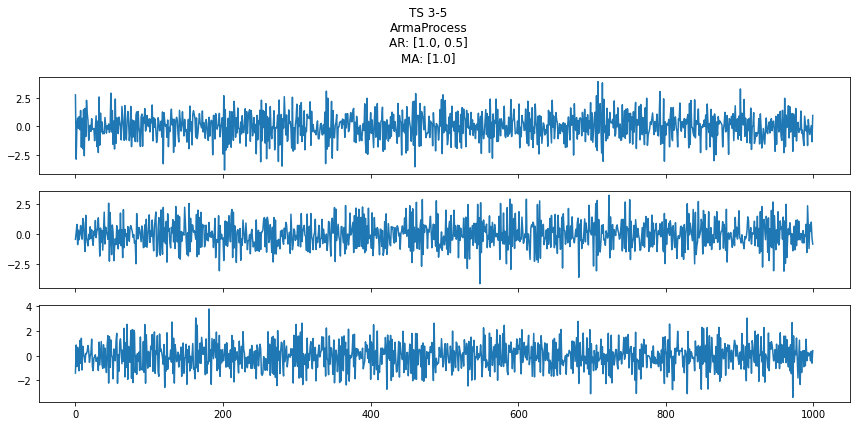

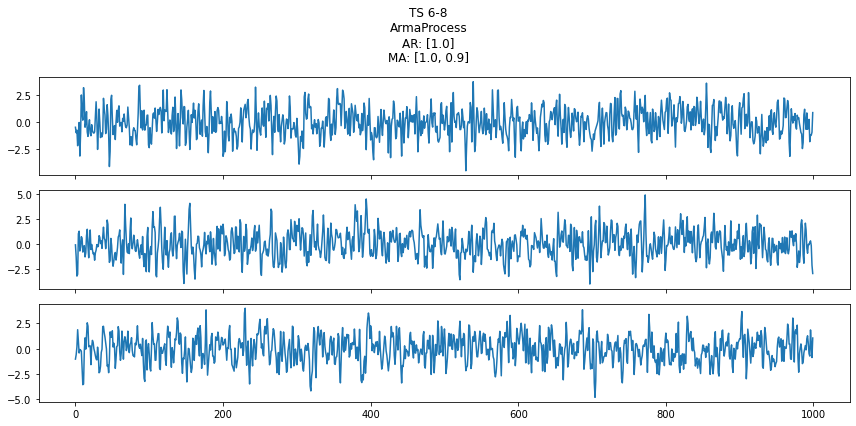

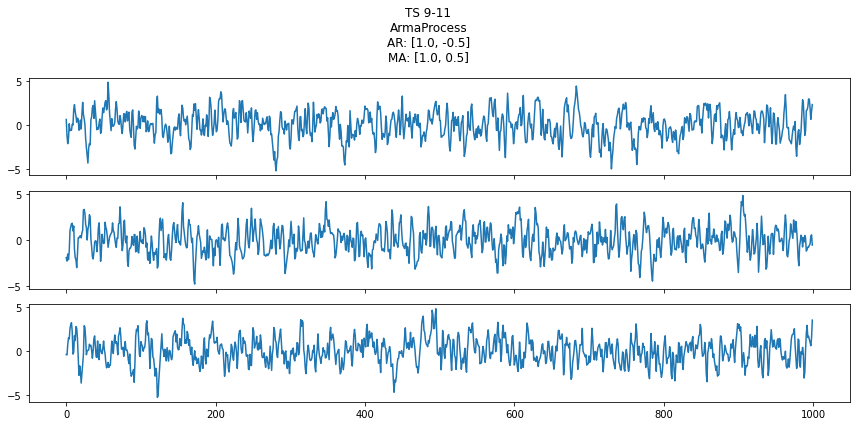

In [6]:
for i in range(n_processes):
    lower = i * series_per_process
    upper = lower + series_per_process
    plot_df(df, lower, upper, processes[i])

## 3 Estimate ACFs 

In [7]:
def acf(x, n_lags):
    return sm.tsa.stattools.acf(x, nlags=n_lags)

# Max ACF lags
n_lags = 20

lag_arr = np.repeat(n_lags, df.shape[1])
acf_list = list(map(acf, df.transpose().to_numpy(), lag_arr))
acf_df = pd.DataFrame(acf_list).transpose()
acf_df.columns = df.columns

In [8]:
acf_df.head(10)

,TS_0,TS_1,TS_2,TS_3,TS_4,TS_5,TS_6,TS_7,TS_8,TS_9,TS_10,TS_11
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,0.047832,0.038702,0.014194,-0.489073,-0.485233,-0.496710,0.422718,0.472055,0.503700,0.734496,0.690057,0.710226
2,0.058599,-0.029423,0.035825,0.246468,0.216333,0.249287,-0.094979,-0.048218,0.011372,0.412276,0.307882,0.365925
3,-0.028624,-0.055625,0.073714,-0.140340,-0.095229,-0.137738,0.024511,-0.021790,0.023593,0.250028,0.119927,0.218202
4,0.015389,0.006992,-0.008646,0.084548,0.066341,0.092071,0.098110,-0.009813,0.012000,0.166173,0.033444,0.140198
5,0.012097,0.014442,-0.071367,-0.042184,-0.028776,-0.042676,0.023846,-0.017538,-0.045108,0.106849,-0.001923,0.096768
6,0.016730,-0.032940,-0.041925,0.067511,0.020913,0.023689,-0.063139,-0.015976,-0.060018,0.049393,-0.030190,0.065923
7,-0.038194,-0.043001,0.023577,-0.073964,-0.052277,-0.033168,-0.002610,-0.004829,-0.003866,-0.003346,-0.056727,0.023881
8,0.046854,0.016116,-0.038450,0.106654,-0.002198,0.016850,0.064613,0.021831,0.024768,-0.044170,-0.078125,-0.023349
9,-0.041650,0.033494,0.039917,-0.123561,0.087545,-0.015584,0.044243,-0.001792,-0.016642,-0.035016,-0.054888,-0.039329


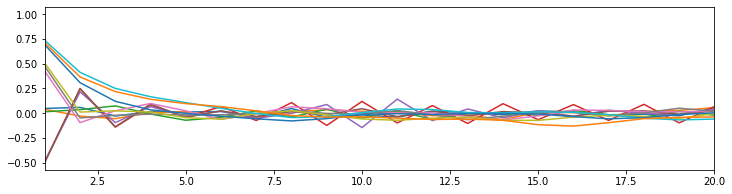

In [9]:
plt.figure(figsize=(12, 3))
plt.xlim((1, n_lags))
plt.plot(acf_df)
plt.show()

## 3 Find clusters

In [10]:
n_clusters = n_processes
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(acf_df.transpose())
kmeans.labels_

array([3, 3, 3, 0, 0, 0, 2, 2, 2, 1, 1, 1], dtype=int32)

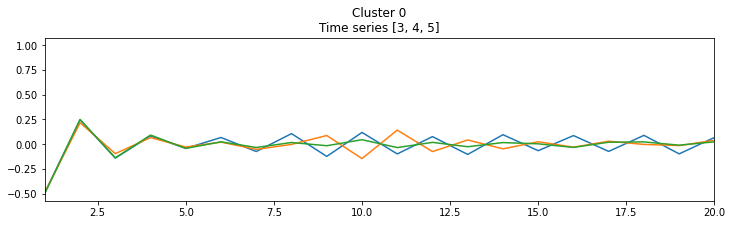

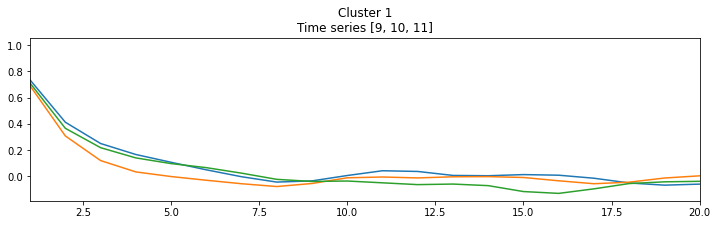

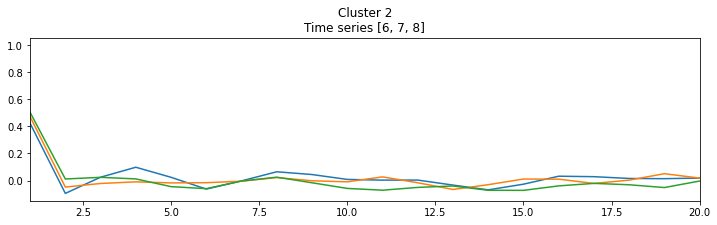

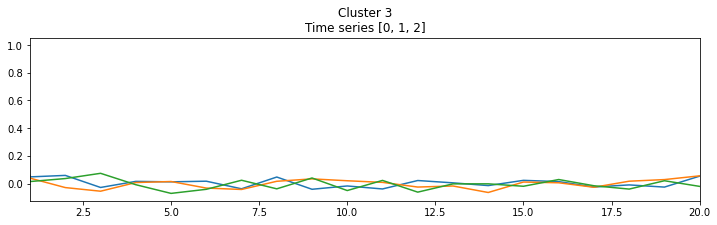

In [11]:
# i ranges over clusters
for i in range(n_clusters):
    plt.figure(figsize=(12, 3))
    plt.xlim((1, n_lags))
    ts = []

    # j ranges over the series ACFs
    for j in range(n_series):
        
        # Plot ACF j in the current cluster i
        if kmeans.labels_[j] == i:
            ts.append(j)
            plt.plot(acf_df.iloc[:, j])
    
    plt.title(f"Cluster {i}\nTime series {ts}")
    plt.show()